In [36]:
import numpy as np
import math
from catboost import Pool, CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt

Assume that we have two categorical features with 9 values each, so there are 81 possible feature combinations. The target y depends on the features x as y = mean(x) + eps(x), where mean(x) is some unknown fixed value and eps(x) is a normally distributed noise with mean 0 and variance var(x). We let mean(x) to be randomly generated and var(x) to have two values - 0.01 and 0.04. Also, there will be an "unknown" region without any training examples. To indicate this region on the figure, we set var(x) = 0 for these feature combinations.

In [37]:
# function for generating mean and variance
def gen_parameters(noise=0.01, seed=0):
    
    np.random.seed(seed)
    
    mean = np.random.rand(9, 9)
    
    figure = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 4, 1, 1, 1, 4, 1, 1],
        [1, 4, 0, 4, 1, 4, 0, 4, 1],
        [4, 0, 0, 0, 4, 0, 0, 0, 4],
        [1, 4, 0, 0, 0, 0, 0, 4, 1],
        [1, 1, 4, 0, 0, 0, 4, 1, 1],
        [1, 1, 1, 4, 0, 4, 1, 1, 1],
        [1, 1, 1, 1, 4, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]
    ])

    var = figure*noise
    
    return mean, var

True data uncertainty (variance). The white region will not contain any traing data.


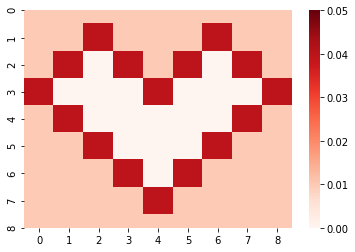

In [38]:
# generate parameters and plot variance
mean, var = gen_parameters()
print("True data uncertainty (variance). The white region will not contain any traing data.")
sns.heatmap(var, cmap="Reds", vmax=0.05)
plt.savefig("heart_data_gt.pdf")
plt.show()

In [39]:
# function for generating train and validation sets
def generate_training_data(n_samples, mean, var, num_cat=9, seed=0):
    np.random.seed(seed)
    train = []
    target = []
    val = []
    val_target = []
    for i in range(num_cat):
        for j in range(num_cat):
            if var[i, j] == 0:
                continue
            for _ in range(n_samples):
                train.append([i, j])
                val.append([i, j])
                target.append(np.random.normal(mean[i, j], math.sqrt(var[i, j])))
                val_target.append(np.random.normal(mean[i, j], math.sqrt(var[i, j])))
                
    train = np.asarray(train)
    target = np.asarray(target)

    return train, target, val, val_target

In [40]:
# generate train and validation datasets
train, target, val, val_target = generate_training_data(1000, mean, var)

train_pool = Pool(train, target, cat_features = [0, 1])
val_pool = Pool(val, val_target, cat_features = [0, 1])

# generate test, consisting of all possible feature combinations
num_cat = 9
test = np.asarray([[i, j] for i in range(num_cat) for j in range(num_cat)])

Let’s generate an ensemble of SGLB models (for this, we use the option posterior_sampling):

In [41]:
def ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.3):
    ens_preds = []
    for seed in range(num_samples):
        model = CatBoostRegressor(random_seed=seed, iterations=iters, learning_rate=lr, 
                                  loss_function='RMSEWithUncertainty', posterior_sampling=True,
                                  bootstrap_type='No', verbose=False)
        model.fit(train_pool, eval_set=val_pool, use_best_model=False)
        print("best iteration =", model.get_best_iteration()) # check that best iteration is reasonable
        ens_preds.append(model.predict(test))
    return ens_preds

ens_preds = ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.3)
ens_preds = np.asarray(ens_preds)

best iteration = 994
best iteration = 999
best iteration = 995
best iteration = 937
best iteration = 984
best iteration = 974
best iteration = 996
best iteration = 955
best iteration = 996
best iteration = 999


For regression, data uncertainty is the average variance predicted by the models, while knowledge uncertainty can be obtained by measuring the variance of the mean across multiple models.

Average predicted data uncertainty:


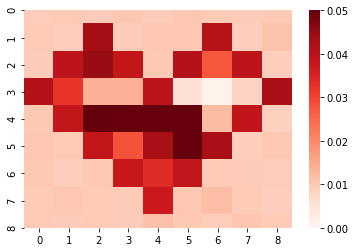

Knowledge uncertainty via ensemble:


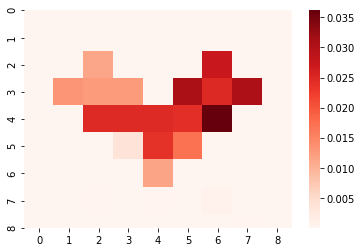

In [42]:
data = np.mean(ens_preds, axis=0)[:, 1] # average estimated data uncertainty
knowledge = np.var(ens_preds, axis=0)[:, 0] # estimated knowledge uncertainty

print("Average predicted data uncertainty:")            
sns.heatmap(data.reshape([num_cat, num_cat]), cmap="Reds", vmin=0, vmax=0.05)
plt.savefig("heart_data_sglb.pdf")
plt.show()

print("Knowledge uncertainty via ensemble:")            
sns.heatmap(knowledge.reshape([num_cat, num_cat]), cmap="Reds")
plt.savefig("heart_knowledge_sglb.pdf")
plt.show()

Let us estimate data and knowledge uncertainty with a virtual ensemble. Here we can also use prediction_type='TotalUncertainty': in this case, CatBoost calculates and returns the following statistics using the virtual ensemble: Mean Predictions, Knowledge Uncertainty, Data Uncertainty

In [43]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.3, loss_function='RMSEWithUncertainty', 
                          posterior_sampling=True, bootstrap_type='No', random_seed=0, verbose=False)
model.fit(train_pool, eval_set=val_pool, use_best_model=False)
preds = model.virtual_ensembles_predict(test, prediction_type='TotalUncertainty', virtual_ensembles_count=10)

Average predicted data uncertainty:


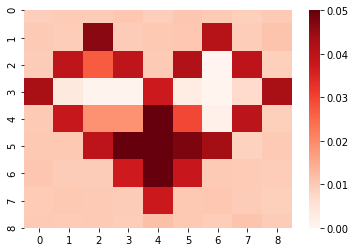

Knowledge uncertainty via virtual ensemble:


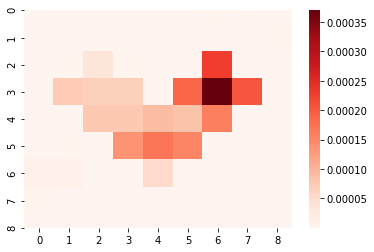

In [44]:
mean_preds = preds[:,0] # mean values predicted by a virtual ensemble

data = preds[:,2] # estimated data uncertainty
print("Average predicted data uncertainty:")
sns.heatmap(data.reshape([num_cat,num_cat]), cmap="Reds", vmin = 0, vmax = 0.05)
plt.savefig("heart_data_vsglb.pdf")
plt.show()

knowledge = preds[:,1] # knowledge uncertainty
print("Knowledge uncertainty via virtual ensemble:")
sns.heatmap(knowledge.reshape([num_cat,num_cat]), cmap="Reds")
plt.savefig("heart_knowledge_vsglb.pdf")
plt.show()

Now, let us do the same for SGB ensembles. In this case, we do not use posterior_sampling and instead set bootstrap_type='Bernoulli' and subsample=0.5. Note that a smaller learning rate is needed for convergence. 

In [20]:
def ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.1):
    ens_preds = []
    for seed in range(num_samples):
        model = CatBoostRegressor(random_seed=seed, iterations=iters, learning_rate=lr, 
                                  loss_function='RMSEWithUncertainty', subsample=0.5,
                                  bootstrap_type='Bernoulli', verbose=False)
        model.fit(train_pool, eval_set=val_pool, use_best_model=False)
        print("best iteration =", model.get_best_iteration()) # check that best iteration is reasonable
        ens_preds.append(model.predict(test))
    return ens_preds

ens_preds = ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.1)
ens_preds = np.asarray(ens_preds)

best iteration = 858
best iteration = 483
best iteration = 702
best iteration = 393
best iteration = 538
best iteration = 419
best iteration = 519
best iteration = 552
best iteration = 474
best iteration = 450


Average predicted data uncertainty:


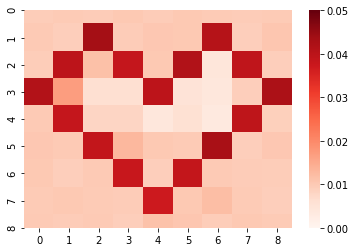

Knowledge uncertainty via ensemble:


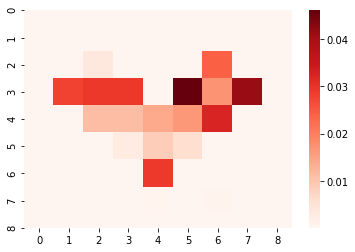

In [11]:
data = np.mean(ens_preds, axis=0)[:, 1] # average estimated data uncertainty
knowledge = np.var(ens_preds, axis=0)[:, 0] # estimated knowledge uncertainty

print("Average predicted data uncertainty:")            
sns.heatmap(data.reshape([num_cat, num_cat]), cmap="Reds", vmin=0, vmax=0.05)
# plt.savefig("heart_data_sgb.pdf")
plt.show()

print("Knowledge uncertainty via ensemble:")            
sns.heatmap(knowledge.reshape([num_cat, num_cat]), cmap="Reds")
# plt.savefig("heart_knowledge_sgb.pdf")
plt.show()

In [12]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, loss_function='RMSEWithUncertainty', 
                          subsample=0.5, bootstrap_type='Bernoulli', random_seed=0, verbose=False)
model.fit(train_pool, eval_set=val_pool, use_best_model=False)
preds = model.virtual_ensembles_predict(test, prediction_type='TotalUncertainty', virtual_ensembles_count=10)

Average predicted data uncertainty:


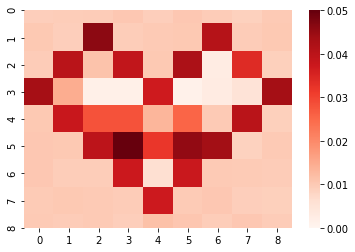

Knowledge uncertainty via virtual ensemble:


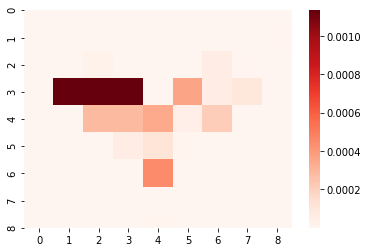

In [13]:
mean_preds = preds[:,0] # mean values predicted by a virtual ensemble

data = preds[:,2] # estimated data uncertainty
print("Average predicted data uncertainty:")
sns.heatmap(data.reshape([num_cat,num_cat]), cmap="Reds", vmin = 0, vmax = 0.05)
# plt.savefig("heart_data_vsgb.pdf")
plt.show()

knowledge = preds[:,1] # knowledge uncertainty
print("Knowledge uncertainty via virtual ensemble:")
sns.heatmap(knowledge.reshape([num_cat,num_cat]), cmap="Reds")
# plt.savefig("heart_knowledge_vsgb.pdf")
plt.show()